# Parking Availability Prediction Workflow

## 1. Libraries
Import all necessary libraries for data processing, modeling, and visualization.

In [ ]:
# flake8: noqa
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


## 2. Data Conversion
Convert `.npz` files to `.csv` for easier data manipulation.

In [12]:
# def npz_to_csv(npz_path, csv_path):
#     data = np.load(npz_path)
#     x = data['x']
#     y = data['y']
    
#     x_flat = x.reshape(-1, x.shape[-1])
#     y_flat = y.reshape(-1, 1)
    
#     combined = np.hstack((x_flat, y_flat))
#     columns = [f'feature_{i}' for i in range(x_flat.shape[1])] + ['label']
#     df = pd.DataFrame(combined, columns=columns)
#     df.to_csv(csv_path, index=False)
#     print(f"CSV saved successfully as '{csv_path}'")

# # Usage
# npz_to_csv('test.npz', 'test.csv')
# npz_to_csv('train.npz', 'train.csv')

## 3. Data Inspection
Load and inspect the training and test datasets.

In [13]:
df_train = pd.read_csv("train.csv")
# print(df_train.head(20))

df_test = pd.read_csv("test.csv")


## 4. Data Cleaning
Rename columns for better readability and understanding.

In [14]:
print(df_train.columns)

df_train.rename(columns={
    'feature_0': 'Parking Availability', # Parking spot availability
    'feature_1': 'Time of day', # 15 mins = 1 => 24 hours × 4 = 96 quarter-hour intervals
    'feature_2': 'Weekday', # 0 = Monday, 1 = Tuesday, ..., 6 = Sunday
    'feature_3': 'Is_holiday', # 0 = No, 1 = Yes
    'feature_4': 'Temperature', # Normalized 
    'feature_5': 'Humidity', # Normalized
    'feature_6': 'Windspeed', # Normalized
    'feature_7': 'Utilization Type',
    'feature_8': 'Planning area',
    'feature_9': 'Road Density', # Normalized
    'feature_10': 'Latitude',
    'feature_11': 'Longitude',
    'label': 'Actual Availability'  
}, inplace=True)

print(df_train.columns.tolist())

df_test.rename(columns={
    'feature_0': 'Parking Availability',
    'feature_1': 'Time of day',
    'feature_2': 'Weekday',
    'feature_3': 'Is_holiday',
    'feature_4': 'Temperature',
    'feature_5': 'Humidity',
    'feature_6': 'Windspeed',
    'feature_7': 'Utilization Type',
    'feature_8': 'Planning area',
    'feature_9': 'Road Density',
    'feature_10': 'Latitude',
    'feature_11': 'Longitude',
    'label': 'Actual Availability'  
}, inplace=True)

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'label'],
      dtype='object')
['Parking Availability', 'Time of day', 'Weekday', 'Is_holiday', 'Temperature', 'Humidity', 'Windspeed', 'Utilization Type', 'Planning area', 'Road Density', 'Latitude', 'Longitude', 'Actual Availability']


## 5. Feature Engineering
Separate features and target variable. Sample data due to dataset being too large.

In [28]:
X_train = df_train.drop("Actual Availability", axis=1)
y_train = df_train["Actual Availability"]

X_test = df_test.drop("Actual Availability", axis=1)
y_test = df_test["Actual Availability"]

## 6. Preprocessing Pipeline
- **Numerical features:** Standardize values (mean = 0, std = 1)
- **Categorical features:** Binary values

In [29]:
cat_cols = ["Weekday", "Is_holiday", "Utilization Type", "Planning area"]  # adjust as needed

for col in cat_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

## 7. Model Building
Create a pipeline with a Random Forest Regressor.

In [30]:
# Initialize and train the model
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    num_leaves=31,
    random_state=42
)



## 8. Training
Fit the model on the training data.

In [31]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.349003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1751
[LightGBM] [Info] Number of data points in the train set: 24636948, number of used features: 12
[LightGBM] [Info] Start training from score 182.350055


LGBMRegressor(max_depth=10, random_state=42)

## 9. Prediction
Make predictions on the test set.

In [32]:
y_pred = lgb_model.predict(X_test)

## 10. Evaluation
Evaluate model performance using MAE, RMSE, and R² Score.

In [36]:
# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

regression_accuracy = 1 - (mae / y_test.mean())
print(f"Approximate Regression Accuracy: {regression_accuracy:.2%}")



Mean Absolute Error (MAE): 21.47
Root Mean Squared Error (RMSE): 41.41
R² Score: 0.97
Approximate Regression Accuracy: 88.34%


## 11. Visualization
Visualize actual vs. predicted availability.

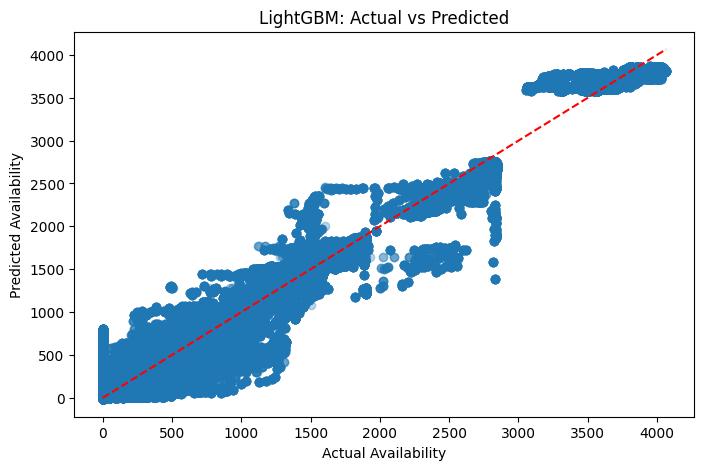

In [34]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Availability')
plt.ylabel('Predicted Availability')
plt.title('LightGBM: Actual vs Predicted')
plt.show()

## 12. Save Results
Store results in a new CSV file for further analysis.

In [35]:
results_df = pd.DataFrame({
    'Actual Availability': y_test.values,
    'Predicted Availability': y_pred
})

results_df.to_csv("actual_vs_predicted_availability.csv", index=False)